<a href="https://colab.research.google.com/github/Murcicrum/analisis-legislativo/blob/main/analisis_legislativo__modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports y carga del dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


np.random.seed(42)

In [2]:
URL_DATASET = 'https://github.com/Murcicrum/analisis-legislativo/raw/main/dataset_final.csv'
df = pd.read_csv( URL_DATASET, index_col=0 )

#### Defino funciones utiles

In [3]:
#Para visualizar la performance del clasificador
def plot_histograms(t_true,t_probas,title:str='', acc=0) -> None:

  fig, axs = plt.subplots(2,1, figsize=(4,8), sharex=True )

  pd.Series(t_probas).hist( by=t_true, bins=20, range=(-10,10), ax=axs)
 
  axs[0].set_title( 'Negativo', x=0.85, pad=3)
  axs[1].set_title('Afirmativo',x=0.15, pad=3)
  
  axs[1].set_xlabel('Funcióndw de decisión')


  for na, ax in enumerate(axs):
    if na==0: ax.set_facecolor('lightsalmon')
    if na==1: ax.set_facecolor('lightgreen')

    for i, rect in enumerate(ax.patches):
      if i<len(ax.patches)/2: rect.set_color('r')
      else:                   rect.set_color('g')


  fig.tight_layout()
  fig.suptitle( t=title, fontsize=20, y=1.05)
  fig.text( s=f'Bal. Acc.:{acc:.3f}', x=0.25,y=-0.02, fontsize=15)


In [4]:
#Para ver más ordenados los resultados del gridSearchCV
def show_grid_results(grid_results, all=False) -> None:
  print( 'Best estimator: \n', grid_results.best_estimator_ )
  print( '\nBest score: ', grid_results.best_score_  )
  
  if all:
    print('\nrank \t score \t\t\t parametros')
    for rank, score, para in zip(grid_results.cv_results_['rank_test_score'],grid_results.cv_results_['mean_test_score'], grid_results.cv_results_['params']):
      print(rank, '\t',score, '\t\t', para)

#Repaso del dataset

In [5]:
df.columns

Index(['acta_id', 'es_oficialismo', 'b1_presencia', 'b1_apoyo', 'b2_presencia',
       'b2_apoyo', 'b3_presencia', 'b3_apoyo', 'b4_presencia', 'b4_apoyo',
       'nroperiodo', 'tipo_periodo', 'tipo_mayoria', 'resultado'],
      dtype='object')

In [6]:
df.describe()

,acta_id,es_oficialismo,b1_presencia,b1_apoyo,b2_presencia,b2_apoyo,b3_presencia,b3_apoyo,b4_presencia,b4_apoyo,nroperiodo
count,999.000000,999.000000,999.000000,992.000000,999.000000,947.000000,999.000000,942.000000,999.000000,938.000000,999.000000
mean,1970.935936,0.448448,0.817336,0.577525,0.778418,0.390771,0.740368,0.371505,0.651655,0.543285,133.340340
std,1631.354567,0.497584,0.170758,0.786122,0.227079,0.886671,0.266969,0.898792,0.257467,0.763214,2.368862
min,1.000000,0.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,129.000000
25%,252.500000,0.000000,0.723077,0.913043,0.707317,-0.937500,0.700000,-1.000000,0.521739,0.291667,131.000000
50%,2191.000000,0.000000,0.861538,1.000000,0.857143,1.000000,0.833333,1.000000,0.705882,1.000000,134.000000
75%,3713.500000,1.000000,0.947368,1.000000,0.926829,1.000000,0.915780,1.000000,0.842105,1.000000,135.000000
max,3963.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,137.000000


Recuerdo del desbalance de clases que había

In [7]:
df.resultado.value_counts()

AFIRMATIVO    890
NEGATIVO      109
Name: resultado, dtype: int64

###Inspección de NaNs

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999 entries, 0 to 998
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   acta_id         999 non-null    int64  
 1   es_oficialismo  999 non-null    int64  
 2   b1_presencia    999 non-null    float64
 3   b1_apoyo        992 non-null    float64
 4   b2_presencia    999 non-null    float64
 5   b2_apoyo        947 non-null    float64
 6   b3_presencia    999 non-null    float64
 7   b3_apoyo        942 non-null    float64
 8   b4_presencia    999 non-null    float64
 9   b4_apoyo        938 non-null    float64
 10  nroperiodo      999 non-null    int64  
 11  tipo_periodo    999 non-null    object 
 12  tipo_mayoria    999 non-null    object 
 13  resultado       999 non-null    object 
dtypes: float64(8), int64(3), object(3)
memory usage: 117.1+ KB


Los NaN se dan en las columnas de apoyo, donde los bloques no se hicieron presentes. Veo cómo esto impactó en el resultado de las elecciones:

In [9]:
df[ df.isna().any(axis=1) ].resultado.value_counts() #[[c for c in df.columns if (c[1]=='_' or c in['tipo_mayoria','resultado'])]]

AFIRMATIVO    69
Name: resultado, dtype: int64

Y en los features de la sesión:

In [10]:
for feature in ['tipo_periodo','tipo_mayoria','es_oficialismo']:
    print( df[ df.isna().any(axis=1) ].groupby([feature,'resultado']).size(), '\n' )
    print( df[feature].value_counts(), '\n\n' )

tipo_periodo    resultado 
Extraordinario  AFIRMATIVO     3
Ordinario       AFIRMATIVO    66
dtype: int64 

Ordinario         836
Extraordinario    132
Prórroga           31
Name: tipo_periodo, dtype: int64 


tipo_mayoria     resultado 
Más de la mitad  AFIRMATIVO    68
Tres cuartos     AFIRMATIVO     1
dtype: int64 

Más de la mitad     883
Dos tercios          54
Tres cuartos         51
La mitad más uno     11
Name: tipo_mayoria, dtype: int64 


es_oficialismo  resultado 
0               AFIRMATIVO     7
1               AFIRMATIVO    62
dtype: int64 

0    551
1    448
Name: es_oficialismo, dtype: int64 




Los NaN se dan en las columnas de apoyo en los casos donde los bloques no se presentaron a votar. Igualmente en todos estos casos resulta que el acta bajo votación fué aprobada.

Es sabido que el hecho de no presentarse a una votación es utilizado como herramienta política para no dar quorum a la sesión y posponer esta y las demás votaciones que se disputen en dicha sesión. Es por esto que cualquier decisión que se tome para trabajar con estos samples introducirá un sesgo en el resultado, y reemplazar los NaNs por algún valor adecuado no es nada trivial.

Considerando que en estos casos el resultado de la votación es Afirmativo (y que esta clase ya se encuentra sobrerepresentada) decido eliminar estas filas. Además puede verse que esto no quita variabilidad a los demas features.

In [11]:
df.dropna(axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

In [12]:
df.resultado.value_counts()

AFIRMATIVO    821
NEGATIVO      109
Name: resultado, dtype: int64

La chance de que un acta resulte aprobada cuando no se ausentó alguno de los 4 bloques con más representantes es $$\frac{821}{821+109}=0.8218$$

###Transformación de features

Resultado pasa a ser binaria

In [13]:
df['resultado'].replace(to_replace={'AFIRMATIVO':1,'NEGATIVO':0}, inplace=True)

Los tipos de periodo y mayoría pasan a ser dummmies

In [14]:
dummies_periodo = pd.get_dummies( data=df.tipo_periodo, prefix='periodo' )
dummies_mayoria = pd.get_dummies( data=df.tipo_mayoria, prefix='mayoria' )

df = df.join( dummies_periodo ).copy()
df = df.join( dummies_mayoria ).copy()

df.drop( columns=['tipo_mayoria','tipo_periodo'], inplace=True )

Llevo la numérica del número de periodo al intervalo [0,1]

In [15]:
scaler = MinMaxScaler()
df.nroperiodo = scaler.fit_transform( df.nroperiodo.values.reshape(-1,1) )

Elimino columna de id's

In [16]:
df.drop( columns='acta_id', inplace=True )

###Separo en set de testeo y entrenamiento

Me quedo con el 80% de los datos para entrenar y el 20% restante para evaluar

In [17]:
x = df.drop(columns='resultado').values.copy()
t = df.resultado.values.copy()
x_train, x_test, t_train, t_test = train_test_split( x,t, test_size=0.2)

In [18]:
x_train.shape, x_test.shape, t_train.shape, t_test.shape

((744, 17), (186, 17), (744,), (186,))

Ahora si estoy en condiciones de entranar un modelo. Voy a probar con un regresor logístico y un SVM, buscando primero los hiperparámetros óptimos para cada modelo. Debido al desbalance de clases que hay, la métrica que utilizo para calificar a los clasificadores es _balanced accuracy_ y voy a asignar pesos a las clases. Por último, aprovechando que hay pocos datos, voy a usar folds grandes. 

#Logit

In [19]:
logreg_clf = LogisticRegression( max_iter=1e6 )

#####Ajuste de hiperparámetros

In [20]:
params = {'class_weight':   [{0:1, 1:1000}, {0:1, 1:100}, {0:1, 1:10}, {0:1, 1:1}, 
                            {1:1, 0:10},  {1:1, 0:100}, {1:1, 0:1000}],
          'C':  np.logspace(-3,3, num=13) }

grid = GridSearchCV(logreg_clf, param_grid=params, scoring='balanced_accuracy', cv=50, verbose=2 )

grid_results = grid.fit( x_train, t_train )

Fitting 50 folds for each of 91 candidates, totalling 4550 fits
[CV] END ..............C=0.001, class_weight={0: 1, 1: 1000}; total time=   0.0s
[CV] END ..............C=0.001, class_weight={0: 1, 1: 1000}; total time=   0.0s
[CV] END ..............C=0.001, class_weight={0: 1, 1: 1000}; total time=   0.0s
[CV] END ..............C=0.001, class_weight={0: 1, 1: 1000}; total time=   0.0s
[CV] END ..............C=0.001, class_weight={0: 1, 1: 1000}; total time=   0.0s
[CV] END ..............C=0.001, class_weight={0: 1, 1: 1000}; total time=   0.0s
[CV] END ..............C=0.001, class_weight={0: 1, 1: 1000}; total time=   0.0s
[CV] END ..............C=0.001, class_weight={0: 1, 1: 1000}; total time=   0.0s
[CV] END ..............C=0.001, class_weight={0: 1, 1: 1000}; total time=   0.0s
[CV] END ..............C=0.001, class_weight={0: 1, 1: 1000}; total time=   0.0s
[CV] END ..............C=0.001, class_weight={0: 1, 1: 1000}; total time=   0.0s
[CV] END ..............C=0.001, class_weight=

In [21]:
grid_results.best_params_

{'C': 1.0, 'class_weight': {0: 10, 1: 1}}

In [22]:
show_grid_results(grid_results, all=True)

Best estimator: 
 LogisticRegression(class_weight={0: 10, 1: 1}, max_iter=1000000.0)

Best score:  0.945934065934066

rank 	 score 			 parametros
75 	 0.5 		 {'C': 0.001, 'class_weight': {0: 1, 1: 1000}}
75 	 0.5 		 {'C': 0.001, 'class_weight': {0: 1, 1: 100}}
75 	 0.5 		 {'C': 0.001, 'class_weight': {0: 1, 1: 10}}
75 	 0.5 		 {'C': 0.001, 'class_weight': {0: 1, 1: 1}}
59 	 0.8212087912087912 		 {'C': 0.001, 'class_weight': {1: 1, 0: 10}}
75 	 0.5 		 {'C': 0.001, 'class_weight': {1: 1, 0: 100}}
75 	 0.5 		 {'C': 0.001, 'class_weight': {1: 1, 0: 1000}}
75 	 0.5 		 {'C': 0.0031622776601683794, 'class_weight': {0: 1, 1: 1000}}
75 	 0.5 		 {'C': 0.0031622776601683794, 'class_weight': {0: 1, 1: 100}}
75 	 0.5 		 {'C': 0.0031622776601683794, 'class_weight': {0: 1, 1: 10}}
75 	 0.5 		 {'C': 0.0031622776601683794, 'class_weight': {0: 1, 1: 1}}
57 	 0.8326373626373624 		 {'C': 0.0031622776601683794, 'class_weight': {1: 1, 0: 10}}
72 	 0.6012637362637363 		 {'C': 0.0031622776601683794, 'class_we

Los mejores desempeños se tienen para valores de C cercanos a la unidad y pesos en torno al 1:10, y la métrica es muchísimo más sensible al cambio de peso de las clases que al factor de penalización.

Hago un ajuste más fino

In [23]:
params = {'class_weight':   [{0:3, 1:1}, {0:6, 1:1}, {0:9, 1:1},
                             {0:11, 1:1},  {0:13, 1:1} ],
          'C':  np.linspace(0.1, 10, 10) }

grid = GridSearchCV(logreg_clf, param_grid=params, scoring='balanced_accuracy', cv=50, verbose=2 )

grid_results = grid.fit( x_train, t_train )

Fitting 50 folds for each of 50 candidates, totalling 2500 fits
[CV] END ...................C=0.1, class_weight={0: 3, 1: 1}; total time=   0.0s
[CV] END ...................C=0.1, class_weight={0: 3, 1: 1}; total time=   0.0s
[CV] END ...................C=0.1, class_weight={0: 3, 1: 1}; total time=   0.0s
[CV] END ...................C=0.1, class_weight={0: 3, 1: 1}; total time=   0.0s
[CV] END ...................C=0.1, class_weight={0: 3, 1: 1}; total time=   0.0s
[CV] END ...................C=0.1, class_weight={0: 3, 1: 1}; total time=   0.0s
[CV] END ...................C=0.1, class_weight={0: 3, 1: 1}; total time=   0.0s
[CV] END ...................C=0.1, class_weight={0: 3, 1: 1}; total time=   0.0s
[CV] END ...................C=0.1, class_weight={0: 3, 1: 1}; total time=   0.0s
[CV] END ...................C=0.1, class_weight={0: 3, 1: 1}; total time=   0.0s
[CV] END ...................C=0.1, class_weight={0: 3, 1: 1}; total time=   0.0s
[CV] END ...................C=0.1, class_weig

In [24]:
show_grid_results(grid_results, all=True)

Best estimator: 
 LogisticRegression(C=6.7, class_weight={0: 11, 1: 1}, max_iter=1000000.0)

Best score:  0.9467032967032968

rank 	 score 			 parametros
50 	 0.9176923076923077 		 {'C': 0.1, 'class_weight': {0: 3, 1: 1}}
33 	 0.9376923076923077 		 {'C': 0.1, 'class_weight': {0: 6, 1: 1}}
48 	 0.9224725274725276 		 {'C': 0.1, 'class_weight': {0: 9, 1: 1}}
49 	 0.9201648351648352 		 {'C': 0.1, 'class_weight': {0: 11, 1: 1}}
38 	 0.9343956043956044 		 {'C': 0.1, 'class_weight': {0: 13, 1: 1}}
39 	 0.9326923076923077 		 {'C': 1.2000000000000002, 'class_weight': {0: 3, 1: 1}}
47 	 0.9278021978021979 		 {'C': 1.2000000000000002, 'class_weight': {0: 6, 1: 1}}
25 	 0.940934065934066 		 {'C': 1.2000000000000002, 'class_weight': {0: 9, 1: 1}}
3 	 0.945934065934066 		 {'C': 1.2000000000000002, 'class_weight': {0: 11, 1: 1}}
5 	 0.9451648351648352 		 {'C': 1.2000000000000002, 'class_weight': {0: 13, 1: 1}}
39 	 0.9326923076923077 		 {'C': 2.3000000000000003, 'class_weight': {0: 3, 1: 1}}
46 	 0.9

##### Modelo final

Elijo los parámetros definitivos del modelo, lo entreno y evaluo la performance en testeo.

In [38]:
logreg_clf = LogisticRegression(C=7, class_weight={0: 11, 1: 1}, max_iter=1e6)

y_pred = cross_val_predict( logreg_clf, x_train, t_train )

logreg_cm = confusion_matrix(t_train, y_pred)
logreg_ba = balanced_accuracy_score(t_train, y_pred)

print('Matriz de confusión: \n',logreg_cm)
print(f'Balanced Accuracy: {logreg_ba:.5f}')

Matriz de confusión: 
 [[ 84   8]
 [ 26 626]]
Balanced Accuracy: 0.93658


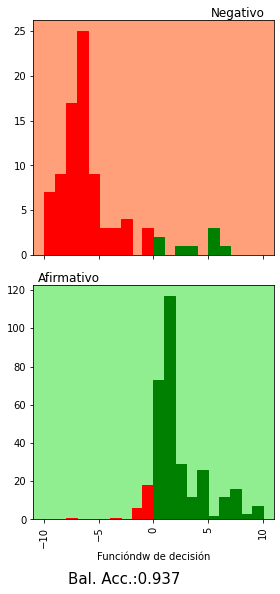

In [39]:
y_decf = cross_val_predict(logreg_clf, x_train, t_train, method='decision_function')
plot_histograms(t_train,y_decf, acc=logreg_ba)

Mientras que el balanced accuracy resultó bastante alto, vemos que el clasificador se equivoca varias veces creyendo estar seguro. Esto lo vemos en el gráfico superior de la clase 0-NEGATIVO, donde asigna como positivos a varios casos donde la función de decisión tomó valores altos (~5). Lo mimso ocurre en el gráfico inferior de la clase 1-AFIRMATIVO, con la salvedad de que aquí el mayor volumen de equivocaciones los comete cerca de la frontera de decisión.

# SVM

##### Hago uno de base

In [27]:
svm_clf = SVC()

y_pred = cross_val_predict(svm_clf,x_train,t_train, cv=50)
cm = confusion_matrix(t_train,y_pred)
ba = balanced_accuracy_score(t_train,y_pred)

print('Matriz de confusión \n',cm)
print(f'Balanced accuracy: {ba:.5f}')

Matriz de confusión 
 [[ 84   8]
 [  2 650]]
Balanced accuracy: 0.95499


Notese que con este SVM de base, el balanced accuracy que obtenemos ya es mayor que el obtenido con el mejor modelo lineal implementado.

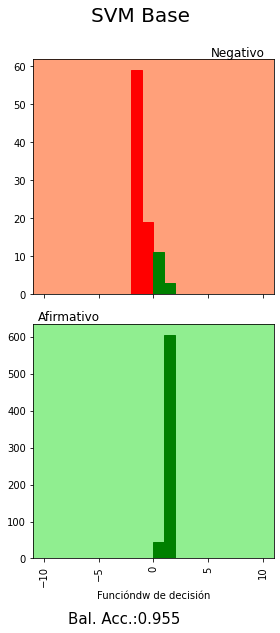

In [28]:
y_decf = cross_val_predict(svm_clf, x_train,t_train, method='decision_function')
plot_histograms(t_train,y_decf,'SVM Base', acc=ba)

#####Busco los hiperparámetros

In [29]:
params={'class_weight':[{0:1, 1:100}, {0:1, 1:10}, {0:1, 1:1}, 
                        {1:1, 0:10},  {1:1, 0:100}] ,
        'kernel':['rbf', 'linear'],
        'C': np.logspace(-2,2,num=5) }

grid = GridSearchCV( SVC(max_iter=1e6), param_grid=params, cv=50,
                     scoring='balanced_accuracy', verbose=2 )

grid_results = grid.fit( x_train,t_train )

Fitting 50 folds for each of 50 candidates, totalling 2500 fits
[CV] END ....C=0.01, class_weight={0: 1, 1: 100}, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, class_weight={0: 1, 1: 100}, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, class_weight={0: 1, 1: 100}, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, class_weight={0: 1, 1: 100}, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, class_weight={0: 1, 1: 100}, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, class_weight={0: 1, 1: 100}, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, class_weight={0: 1, 1: 100}, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, class_weight={0: 1, 1: 100}, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, class_weight={0: 1, 1: 100}, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, class_weight={0: 1, 1: 100}, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, class_weight={0: 1, 1: 100}, kernel=rbf; total time=   0.0s
[CV] END ....C=0.01, class_weight={0: 1, 1: 1

Cómo le fué a clasificadores con los otros parámetros

In [30]:
show_grid_results(grid_results, all=True)

Best estimator: 
 SVC(C=100.0, class_weight={0: 1, 1: 1}, max_iter=1000000.0)

Best score:  0.9711538461538461

rank 	 score 			 parametros
47 	 0.5 		 {'C': 0.01, 'class_weight': {0: 1, 1: 100}, 'kernel': 'rbf'}
47 	 0.5 		 {'C': 0.01, 'class_weight': {0: 1, 1: 100}, 'kernel': 'linear'}
47 	 0.5 		 {'C': 0.01, 'class_weight': {0: 1, 1: 10}, 'kernel': 'rbf'}
46 	 0.505 		 {'C': 0.01, 'class_weight': {0: 1, 1: 10}, 'kernel': 'linear'}
47 	 0.5 		 {'C': 0.01, 'class_weight': {0: 1, 1: 1}, 'kernel': 'rbf'}
35 	 0.8834615384615384 		 {'C': 0.01, 'class_weight': {0: 1, 1: 1}, 'kernel': 'linear'}
30 	 0.8940109890109891 		 {'C': 0.01, 'class_weight': {1: 1, 0: 10}, 'kernel': 'rbf'}
22 	 0.9181318681318682 		 {'C': 0.01, 'class_weight': {1: 1, 0: 10}, 'kernel': 'linear'}
45 	 0.7621978021978022 		 {'C': 0.01, 'class_weight': {1: 1, 0: 100}, 'kernel': 'rbf'}
44 	 0.7675274725274726 		 {'C': 0.01, 'class_weight': {1: 1, 0: 100}, 'kernel': 'linear'}
41 	 0.86 		 {'C': 0.1, 'class_weight': {0: 1,

Ahora hago un ajuste fino, observando que: el rendimiento con el kernel gaussiano es mucho mejor que con el lineal y que también aporta a esto que la clase '0' (resultado NEGATIVO) tenga más peso que la '1' (resultado AFIRMATIVO).

Busco más detalles sobre cuál debiera ser la constante de regularización C y el peso adecuado de las clases.


In [31]:
np.logspace(1,3,9)

array([  10.        ,   17.7827941 ,   31.6227766 ,   56.23413252,
        100.        ,  177.827941  ,  316.22776602,  562.34132519,
       1000.        ])

In [32]:
params = {'class_weight':[{0:1, 1:1}, {0:10, 1:1}, {0:100, 1:1}, {0:1000, 1:1},{0:10000, 1:1}],
          'kernel':['rbf'],
          'C': np.logspace(0,2,num=6) }

grid = GridSearchCV( SVC(max_iter=1e6), param_grid=params, cv=50,
                     scoring='balanced_accuracy', verbose=2)

grid_results = grid.fit(x_train,t_train)

Fitting 50 folds for each of 30 candidates, totalling 1500 fits
[CV] END .......C=1.0, class_weight={0: 1, 1: 1}, kernel=rbf; total time=   0.0s
[CV] END .......C=1.0, class_weight={0: 1, 1: 1}, kernel=rbf; total time=   0.0s
[CV] END .......C=1.0, class_weight={0: 1, 1: 1}, kernel=rbf; total time=   0.0s
[CV] END .......C=1.0, class_weight={0: 1, 1: 1}, kernel=rbf; total time=   0.0s
[CV] END .......C=1.0, class_weight={0: 1, 1: 1}, kernel=rbf; total time=   0.0s
[CV] END .......C=1.0, class_weight={0: 1, 1: 1}, kernel=rbf; total time=   0.0s
[CV] END .......C=1.0, class_weight={0: 1, 1: 1}, kernel=rbf; total time=   0.0s
[CV] END .......C=1.0, class_weight={0: 1, 1: 1}, kernel=rbf; total time=   0.0s
[CV] END .......C=1.0, class_weight={0: 1, 1: 1}, kernel=rbf; total time=   0.0s
[CV] END .......C=1.0, class_weight={0: 1, 1: 1}, kernel=rbf; total time=   0.0s
[CV] END .......C=1.0, class_weight={0: 1, 1: 1}, kernel=rbf; total time=   0.0s
[CV] END .......C=1.0, class_weight={0: 1, 1:

In [33]:
show_grid_results(grid_results, all=True)

Best estimator: 
 SVC(C=6.309573444801933, class_weight={0: 10, 1: 1}, max_iter=1000000.0)

Best score:  0.9753846153846155

rank 	 score 			 parametros
30 	 0.9534615384615384 		 {'C': 1.0, 'class_weight': {0: 1, 1: 1}, 'kernel': 'rbf'}
24 	 0.9657692307692307 		 {'C': 1.0, 'class_weight': {0: 10, 1: 1}, 'kernel': 'rbf'}
25 	 0.965 		 {'C': 1.0, 'class_weight': {0: 100, 1: 1}, 'kernel': 'rbf'}
25 	 0.965 		 {'C': 1.0, 'class_weight': {0: 1000, 1: 1}, 'kernel': 'rbf'}
25 	 0.965 		 {'C': 1.0, 'class_weight': {0: 10000, 1: 1}, 'kernel': 'rbf'}
28 	 0.9626923076923077 		 {'C': 2.51188643150958, 'class_weight': {0: 1, 1: 1}, 'kernel': 'rbf'}
20 	 0.9665384615384616 		 {'C': 2.51188643150958, 'class_weight': {0: 10, 1: 1}, 'kernel': 'rbf'}
20 	 0.9665384615384616 		 {'C': 2.51188643150958, 'class_weight': {0: 100, 1: 1}, 'kernel': 'rbf'}
20 	 0.9665384615384616 		 {'C': 2.51188643150958, 'class_weight': {0: 1000, 1: 1}, 'kernel': 'rbf'}
20 	 0.9665384615384616 		 {'C': 2.51188643150958, 'c

Para este rango de valores de C no parece haber grandes variaciones respecto del peso de las clases.

##### Modelo final
Elijo los parámetros definitivos del modelo, lo entreno y evaluo la performance en testeo.

In [42]:
svm_clf = SVC(C=10, class_weight={0:10,1:1}, kernel='rbf', max_iter=1e6)

y_pred = cross_val_predict(svm_clf, x_train, t_train, cv=50)

svm_cm = confusion_matrix(t_train, y_pred)
svm_ba = balanced_accuracy_score(t_train, y_pred
                                 )
print('Matrix de confusión \n',svm_cm)
print(f'Balanced Accuracy: {svm_ba:.5f}')

Matrix de confusión 
 [[ 88   4]
 [  6 646]]
Balanced Accuracy: 0.97366


En términos absolutos (i.e. del accuracy) el rendimiento de este modelo es el mismo que el del base, puesto que ambos se equivocaron en 10 casos. Sin embargo, este es mejor bajo la métrica que utilizo, ya que acertó más casos de la clase minoritaria.

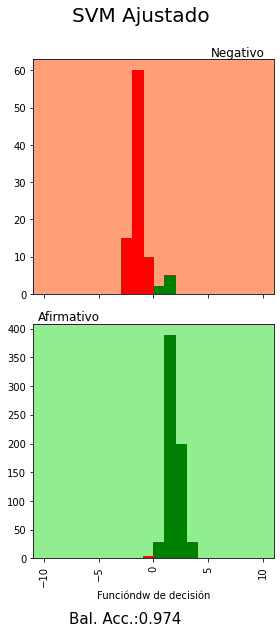

In [43]:
y_decf = cross_val_predict(svm_clf, x_train, t_train, method='decision_function')
plot_histograms(t_train,y_decf, 'SVM Ajustado',acc=svm_ba)

Igual que antes, los errores que comete este modelo están cerca de la frontera de decisión.

# Evaluación en test

#### Logit

In [51]:
logreg_clf = LogisticRegression(C=7, class_weight={0: 11, 1: 1}, max_iter=1e6)
logreg_clf.fit(x_train,t_train)

logreg_y = logreg_clf.predict(x_test)
logreg_cm = confusion_matrix(t_test, logreg_y)
logreg_ba = balanced_accuracy_score(t_test, logreg_y)

print('Logistic Regressor final')
print('Matriz de confusión: \n', logreg_cm)
print(f'Balanced Accuracy: {logreg_ba:.5f}')

Logistic Regressor final
Matriz de confusión: 
 [[ 15   2]
 [  5 164]]
Balanced Accuracy: 0.92638


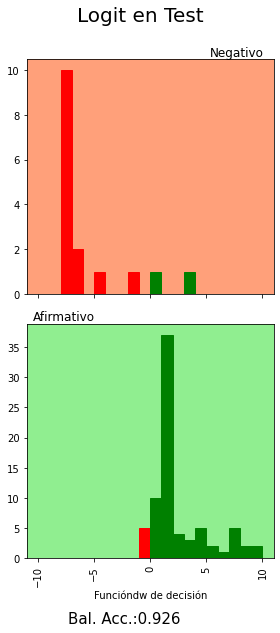

In [52]:
plot_histograms(t_test, logreg_clf.decision_function(x_test),'Logit en Test',acc=logreg_ba)

#### SVM

In [47]:
svm_clf = SVC(C=10, kernel='rbf', class_weight={0:10,1:1}, max_iter=1e6)
svm_clf.fit(x_train, t_train)

svm_y = svm_clf.predict(x_test)
svm_cm = confusion_matrix(t_test, svm_y)
svm_ba = balanced_accuracy_score(t_test, svm_y)

print('SVM final')
print('Matriz de confusión: \n', svm_cm)
print(f'Balanced Accuracy: {svm_ba:.5f}')

SVM final
Matriz de confusión: 
 [[ 16   1]
 [  2 167]]
Balanced Accuracy: 0.96467


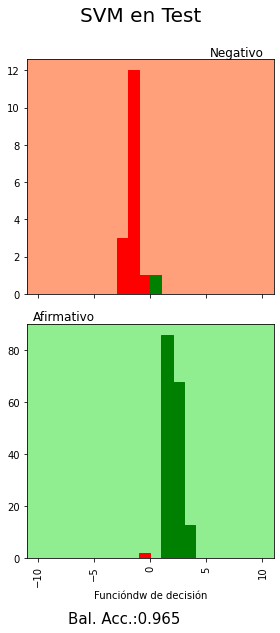

In [50]:
plot_histograms(t_test, svm_clf.decision_function(x_test),'SVM en Test',acc=svm_ba)

#Conclusión

Se concluye directamente entonces que el SVM es un mejor modelo para esta tarea que el regresor logístico. \\
Como es sabido, ambos clasificadores bajaron su performance en la instancia de 
testeo, el regresor logístico un poco más que el svm, pero estas caidas no son muy significativas.

In [45]:
#LOGIT test / train
print('LOGIT', 0.92638/0.93658)

#SVM test / train
print('SVM',0.96467/0.97366)

LOGIT 0.9891093126054368
SVM 0.9907667974446933


Sin embargo hay que recordar que este modelo no es aplicable a sesiones donde se ausente el total de los miembros de alguno de los bloques mayoritarios. Más aún, que no estamos considerando los asuntos que están en votación en dicha sesión, sino sólo cómo responden los miembros de los bloques mayoritarios. 

Esta última aclaración es importante ya que aquí se dá igual importancia a todas las votaciones independientemente del nivel de relevancia directa o impacto que tienen en la sociedad. No se puede suponer que los proyectos de ley que generan más revuelo y son mediatizadas (como la Ley Justina referente al transplante de órganos, la Ley Micaela sobre capacitación de género en instituciones públicas o la Ley de Presupuesto anual) tengan la misma proporción de resultados AFIRMATIVO/NEGATIVO que se tiene en el total de las sesiones, donde hay también votaciones sobre aspectos meramendte técnicos y administrativos.

Por último, muchos diputados/as pertenecientes a estos bloques mayoritarios suelen compartir a través de sus redes sociales una opinión sobre el voto que emitirán en una votación importante. Con lo cual a futuro podría refinarse esta tarea con datos más recientes y quizá otros tipos de modelo, tratar de inferir los valores de _indice de aprobación_ y _porcentaje de presencia_ de los bloques mayoritarios a partir de datos de redes sociales y hacer predicciones sobre futuras votaciones.